# Task 5: Learning Crowd Dynamics

In [5]:
# All imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import math
import utils
from sklearn.decomposition import PCA
from scipy.interpolate import RBFInterpolator

%reload_ext autoreload
%autoreload 2

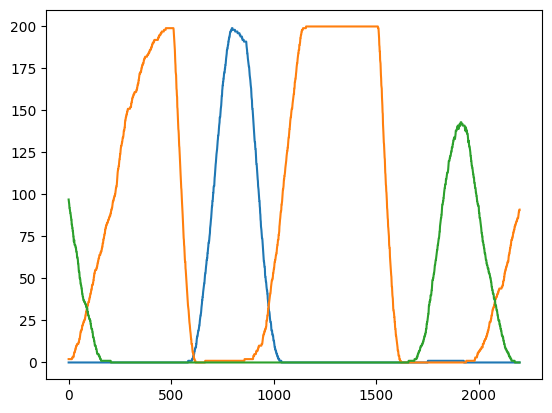

In [6]:
data = np.loadtxt('../../data/MI_timesteps.txt')
data_1 = data[1000:, 1:4]
#plt.plot(data_1[:,0],data_1[:,1])
#plt.plot(data_1[:,0],data_1[:,2])
#plt.plot(data_1[:,0],data_1[:,3])
plt.plot(data_1[:2200])

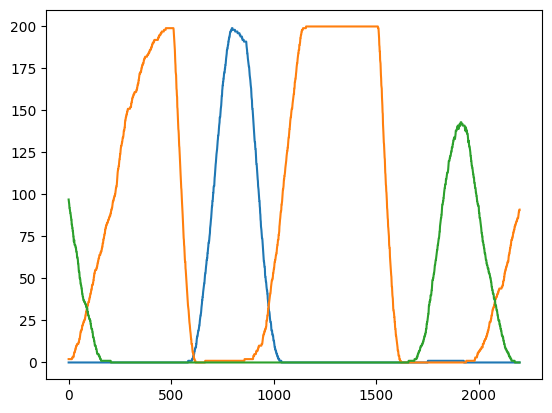

In [7]:
#plt.plot(data_1[:,0],data_1[:,1])
#plt.plot(data_1[:,0],data_1[:,2])
#plt.plot(data_1[:,0],data_1[:,3])
plt.plot(data_1[:2200])

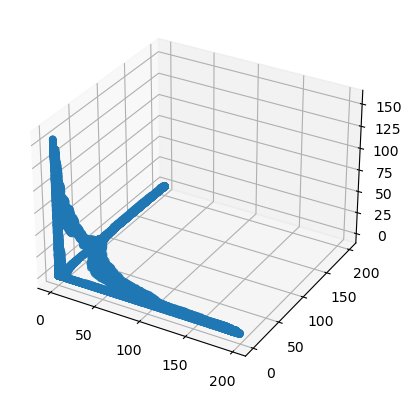

In [79]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(*data_1.T)
plt.show()

### TODO: Task 5.1 - Create a delay embedding with 350 delays of the first three measurement areas

In [10]:
# Number of delays
num_delays = 350
num_areas = 3  # Columns per window
# Create delay windows
windows = utils.create_windows(data_1, num_delays, num_areas)

In [11]:
windows_centered = utils.center_data(windows)

In [12]:
# TODO: Compute SVD
#U, S, Vt = utils.compute_svd(windows_centered)

In [13]:
pca = PCA(n_components=3)  # Choose the number of components you want to keep
principal_components = pca.fit_transform(windows)

In [14]:
principal_components.shape

(13651, 3)

### TODO: Task 5.2 - Create 9 plots - one for each measurement area

In [17]:
#take original measurement data ignoring 1000 timesteps burn-in period, loading the 9 measurements areas data
x_original = data[1000:,1:]

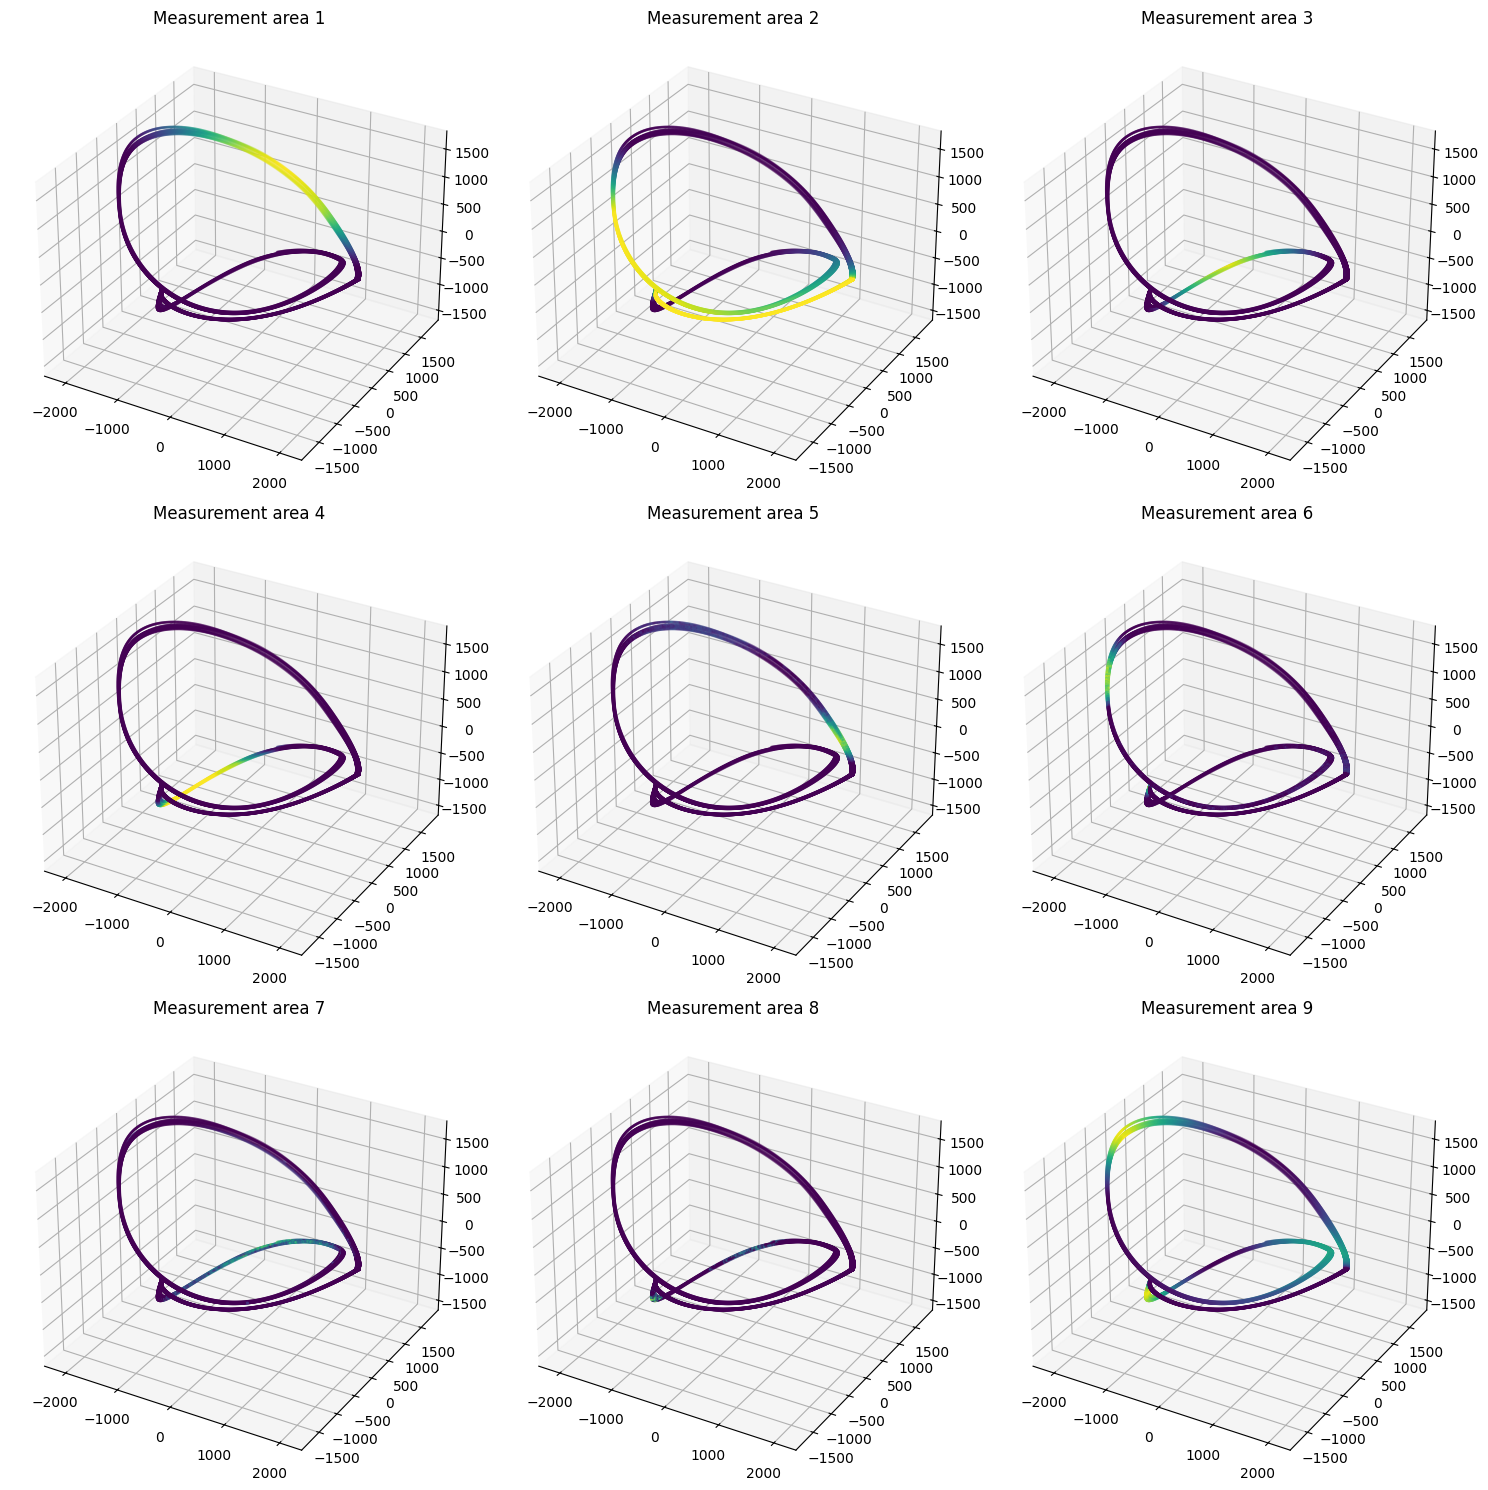

In [19]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15), subplot_kw={'projection': '3d'})
for i in range(9):
    row = i // 3  # Determine row index (0, 1, 2)
    col = i % 3   # Determine column index (0, 1, 2)
    ax = axs[row,col]
    ax.scatter(*principal_components.T, s=1, c=x_original[:len(principal_components), i])
    ax.set_title('Measurement area ' + str(i+1))
    #plt.show()

plt.tight_layout()
plt.show()

### TODO: Task 5.3 - Learn the dynamics on the periodic curve you embedded in the principal components.

In [156]:
principal_components

array([[-8.97581528e+00,  9.25937107e+02, -4.15524719e+02],
       [ 3.48337177e-01,  9.26655864e+02, -4.11482760e+02],
       [ 9.66997427e+00,  9.27306418e+02, -4.07465878e+02],
       ...,
       [-1.59340846e+03, -7.99392225e+01, -1.22164022e+03],
       [-1.59391876e+03, -7.85183877e+01, -1.22483051e+03],
       [-1.59437312e+03, -7.70095346e+01, -1.22795324e+03]])

In [21]:
# Compute arclengths
arclengths = np.zeros(len(principal_components))
for i in range(1, len(principal_components)):
    arclengths[i] = arclengths[i-1] + np.linalg.norm(principal_components[i] - principal_components[i-1])

In [22]:
# Compute change of arclength over time
change_of_arclength = np.diff(arclengths)

(0.0, 25000.0)

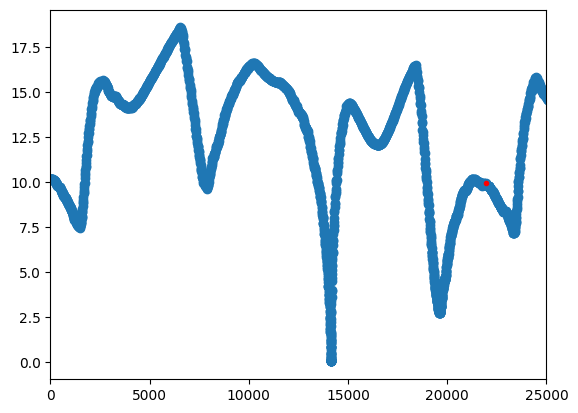

In [35]:
#ground truth
plt.scatter(arclengths[:-1], change_of_arclength)
plt.scatter(arclengths[2000], change_of_arclength[2000],marker='.', color='r')
plt.xlim(0,25000)

(0.0, 2000.0)

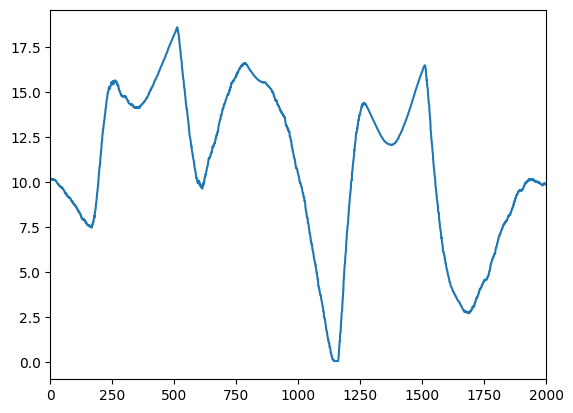

In [161]:
plt.plot(change_of_arclength)
plt.xlim(0,2000)

We can indentify a period of roughly 2000 timesteps (1 day)

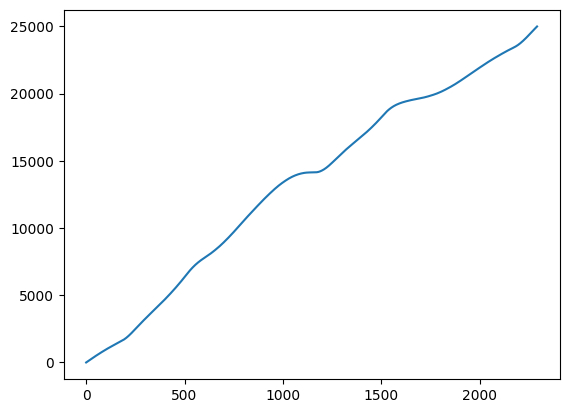

In [24]:
plt.plot(np.where(arclengths <= 25000)[0],arclengths[:len(np.where(arclengths <= 25000)[0])])
#plt.ylim(0,25000)

In [89]:
#total length of the PCA curved arc
arclengths[-1]

array([149454.2841094])

In [42]:
arclengths = arclengths.reshape(len(arclengths),1)

In [170]:
time_pca = np.arange(len(change_of_arclength)).reshape(len(change_of_arclength),1)
time_pca.shape

(13650, 1)

In [167]:
len(time_pca)

13650

In [163]:
L = 2000
#x = np.linspace(-4.5, 4.5, L)
centers = len(change_of_arclength)*np.random.random_sample((L,1))

In [171]:
phi = utils.approx_non_linear_field(time_pca,centers, 0.015)
C =  utils.least_squares(phi.T, change_of_arclength)
approx_field_2 = np.dot(phi.T, C)

utils.mean_squared_error(change_of_arclength.reshape(len(change_of_arclength),1), approx_field_2.reshape(len(approx_field_2),1))

0.8495146463327365

(0.0, 50000.0)

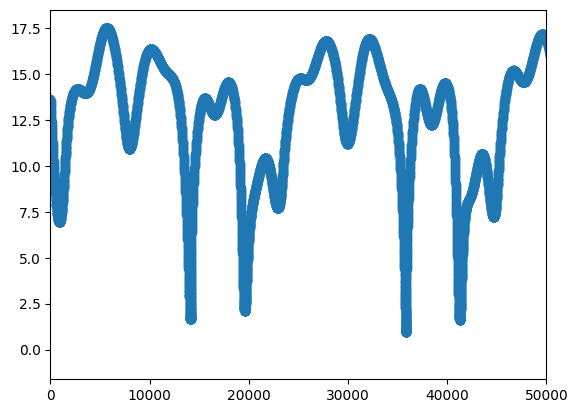

In [172]:
# approximation
plt.scatter(arclengths[:-1], approx_field_2)
plt.xlim(0,50000)

(0.0, 2000.0)

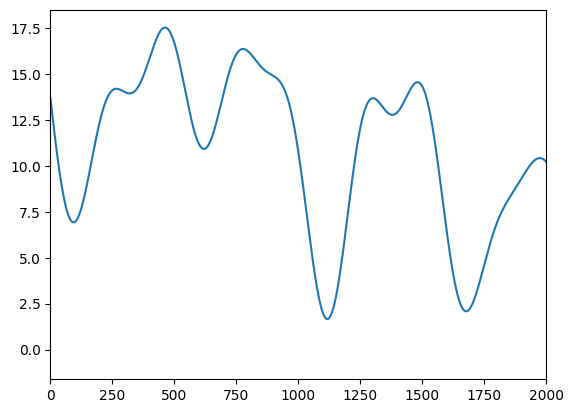

In [173]:
plt.plot(approx_field_2)
plt.xlim(0,2000)

In [174]:
approx_arclengths = np.cumsum(approx_field_2)

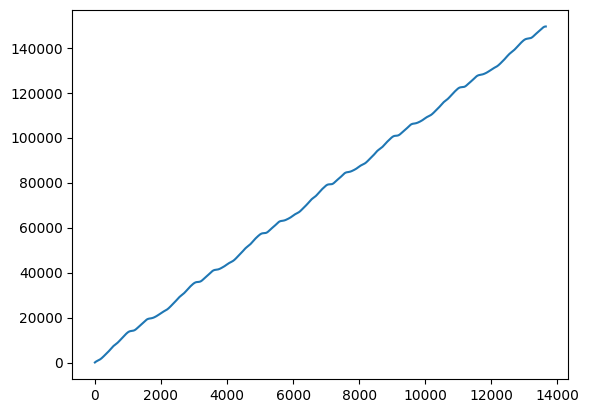

In [175]:
plt.plot(approx_arclengths)

### TODO: Task 5.4 Prediction of utilization of the MI building 

We need to integrate the arclength vector field over time to get a prediction of the arclength values.

In [124]:
# measurement are number 1, MI building
MI_data = data_1[:,0:1]

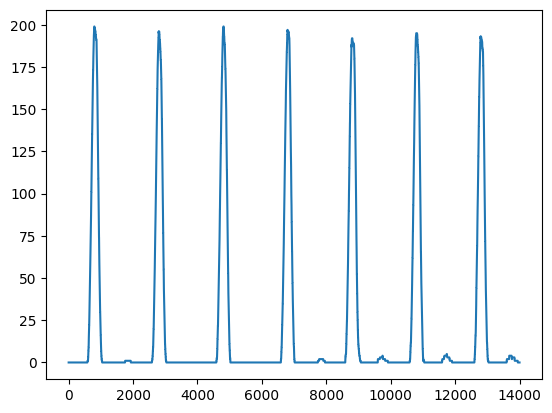

In [125]:
plt.plot(MI_data)

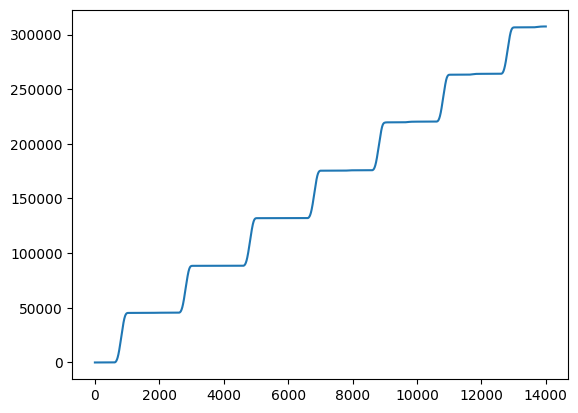

In [126]:
plt.plot(np.cumsum(MI_data))

predicted_arclengths = np.zeros(len(arclengths))
predicted_arclengths[0] = arclengths_period[-1]

for i in range(1, len(arclengths)):
    print(i)
    predicted_arclengths[i] = predicted_arclengths[i-1] + change_of_arclength[i-1]

In [127]:
# define f, f(t,y)= dy/dt where y is the arclength
def f(t,y):
    pass

In [128]:
approx_field_2 = approx_field_2.reshape((len(approx_field_2),1))

In [129]:
predicted_MI_cheat = RBFInterpolator(np.cumsum(approx_field_2).reshape(len(approx_field_2),1), MI_data[0:len(approx_field_2)],
                                kernel='gaussian', epsilon=0.08)(np.cumsum(approx_field_2).reshape(len(approx_field_2),1))

utils.mean_squared_error(predicted_MI_cheat,MI_data[:len(predicted_MI_cheat)])

7.463772505433255e-13

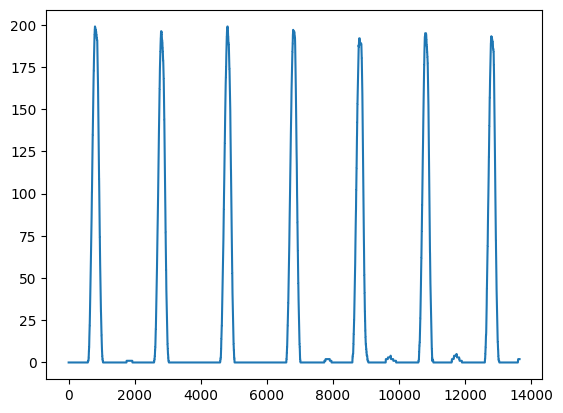

In [131]:
plt.plot(predicted_MI_cheat)

In [176]:
L_2 = 2000
#x = np.linspace(-4.5, 4.5, L)
centers_2 = approx_arclengths[-1]*np.random.random_sample((L_2,1))

In [177]:
approx_arclengths = approx_arclengths.reshape(len(approx_arclengths),1)

In [178]:
# fitting nonlinear approximation
phi_pred = utils.approx_non_linear_field(approx_arclengths,centers_2, 0.008)
C_pred =  utils.least_squares(phi_pred.T, MI_data[:len(approx_arclengths)])
predicted_MI = np.dot(phi_pred.T, C_pred)

utils.mean_squared_error(MI_data[:len(approx_arclengths)], predicted_MI)

0.6627537504795358

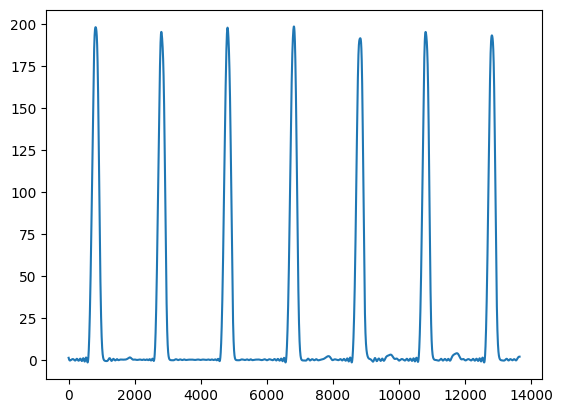

In [188]:
plt.plot(predicted_MI)

In [179]:
time_pca

array([[    0],
       [    1],
       [    2],
       ...,
       [13647],
       [13648],
       [13649]])

MSE of 0.66, quite good!

First we predict the vector field over the next 14 days.

In [190]:
# prediction next 14 days, knowing 7 days are 14001 timestamps
next_14_days = np.arange(time_pca[-1]+1, time_pca[-1] + 1 + 2*len(data_1))
L = 2000
centers_14 = len(next_14_days)*np.random.random_sample((L,1)) + next_14_days[0]
phi_14 = utils.approx_non_linear_field(next_14_days.reshape(len(next_14_days),1),centers_14, 0.015)
approx_field_14_days = np.dot(phi_14.T, C)

C:\Users\Augustin\AppData\Local\Temp\ipykernel_25036\1040779848.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_14_days = np.arange(time_pca[-1]+1, time_pca[-1] + 1 + 2*len(data_1))


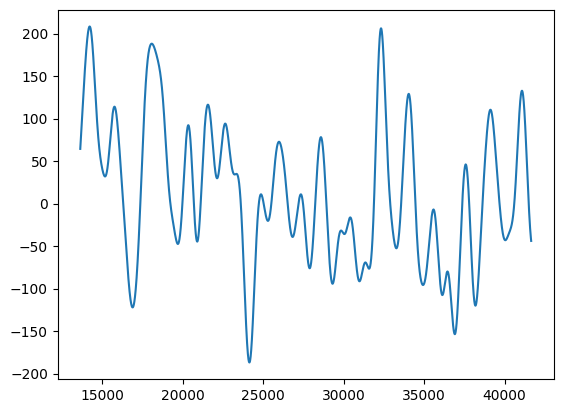

In [194]:
plt.plot(next_14_days,approx_field_14_days)
#plt.plot(next_14_days, np.cumsum(approx_field_14_days))

In [198]:
# Actually predicting utilization

phi_pred_2 = utils.approx_non_linear_field(np.cumsum(approx_field_14_days).reshape(len(approx_field_14_days),1),centers_2, 0.008)
predicted_MI_2 = np.dot(phi_pred_2.T, C_pred)

In [199]:
predicted_MI_2.shape

(28002, 1)

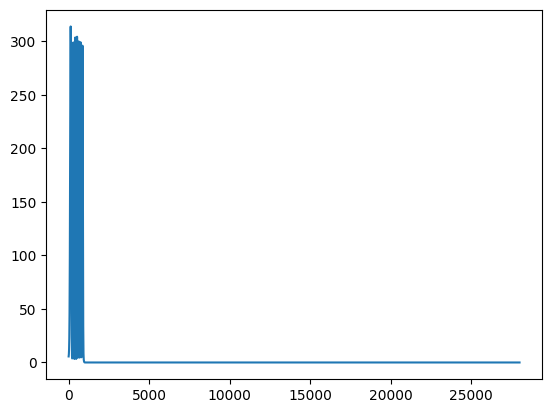

In [200]:
plt.plot(predicted_MI_2)